In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import evaluation
import FEM
import FEM_WEB
import importlib
import mesh
import Geomertry
from network_defs import load_test_model

# Use float64 for better numerical accuracy
torch.set_default_dtype(torch.float64)

## Initializing
Circle , analytical SDF
- DIVISION = 100
- ORDER = 3
- TEST CASE = 3
- SUBDIV = 4

In [2]:
#model = load_test_model("SIREN_circle", "SIREN", params={"architecture": [2, 256, 256, 256, 1], "w_0": 15.0, "w_hidden": 30.0})
model = Geomertry.AnaliticalDistanceCircle()
DIVISIONS = 100
ORDER = 3
DELTA = 0.005

FEM.MAX_SUBDIVISION = 4
#defining geometry:
default = mesh.getDefaultValues(div=DIVISIONS,order=ORDER,delta=DELTA)
x0, y0,x1,y1,xDivision,yDivision,p,q = default
knotvector_u, knotvector_w,weigths, ctrlpts = mesh.generateRectangularMesh(*default)
assert p==q and xDivision == yDivision
x = np.linspace(x0,x1,10)
y = np.linspace(y0,y1,10)
NControl_u = len(knotvector_u)-p-1
NControl_w = len(knotvector_w)-q-1

K = np.zeros(((xDivision+p+1)*(yDivision+q+1),(xDivision+p+1)*(yDivision+q+1)))
F = np.zeros((xDivision+p+1)*(yDivision+q+1))
print("Initialisation finished")


Initialisation finished


## Building K and F with different methods

### K F classic method

In [3]:

K_c, F_c, etype_c = FEM.processAllElements(model, p, q, knotvector_u, knotvector_w, 
                                      xDivision, yDivision, K, F)


Processing boundary elements: 100%|██████████| 8121/8121 [09:01<00:00, 14.99elem/s] 


### K F WEB splines

In [4]:
K_W, F_W, etype_W, bsp_class_W, ext_basis_W = FEM_WEB.processAllElementsWEB(model,p,q,knotvector_u,knotvector_w,
                                              xDivision,yDivision,extension_strict=True,web_use_weight_normalization=False)

WEB-SPLINES (Weighted Extended B-splines) Assembly

[1/4] Classifying elements...
      Inner elements:    7721
      Boundary elements: 400
      Outer elements:    2080

[2/4] Classifying B-splines (Höllig)...
      Inner B-splines: 8324
      Outer B-splines: 412
      Outside domain:  2080

[3/4] Computing extension coefficients (Höllig exact, strict)...
      Extended 412 outer B-splines

[4/4] Building extended basis...

      Assembling system...


Processing boundary elements: 100%|██████████| 8121/8121 [10:01<00:00, 13.50elem/s] 


      System size: 8324 x 8324


### With extraction matrix

In [5]:
K_tilde, F_tilde, etype_extr, bsp_class_extr, ext_basis_extr, E_tilde = FEM_WEB.transformStandardSystemToWEB(
            K,
            F,
            model,
            p,
            q,
            knotvector_u,
            knotvector_w,
            xDivision,
            yDivision,
            extension_strict=True,
            web_use_weight_normalization=False,
            web_ref_weight_eps=1e-6,
        )

### With smart extraction

In [6]:
K_tilde_s, F_tilde_s, etype_s, diag_meta_s, E_tilde_s = FEM_WEB.transformStandardSystemToWEBSelectiveDiagonalExtraction(
            K,
            F,
            model,
            p,
            q,
            knotvector_u,
            knotvector_w,
            xDivision,
            yDivision,
            diag_threshold=1e-11,
            diag_nonzero_eps=0.0,
            extension_strict=True,
        )

Total B-splines: 10816, Inner: 8324, Outer: 412
Selective extraction: extracting 188/412 outer B-splines with |K_jj| < 1e-11 (and > 0); keeping 224 outer DOFs.


### Get reduced mtxs

In [7]:
# classic
non_zero_rows = np.any(K != 0, axis=1) 
K_reduced = K[non_zero_rows][:, non_zero_rows]
F_reduced = F[non_zero_rows]

# web
non_zero_rows_W = np.any(K_W != 0, axis=1)
K_reduced_W = K_W[non_zero_rows_W][:, non_zero_rows_W]
F_reduced_W = F_W[non_zero_rows_W]

# web + transform
non_zero_rows_tilde = np.any(K_tilde != 0, axis=1)
K_reduced_tilde = K_tilde[non_zero_rows_tilde][:, non_zero_rows_tilde]
F_reduced_tilde = F_tilde[non_zero_rows_tilde]

# web + selective diag extract
non_zero_rows_tilde_s = np.any(K_tilde_s != 0, axis=1)
K_reduced_tilde_s = K_tilde_s[non_zero_rows_tilde_s][:, non_zero_rows_tilde_s]
F_reduced_tilde_s = F_tilde_s[non_zero_rows_tilde_s]

### Spy on reduced mtxs

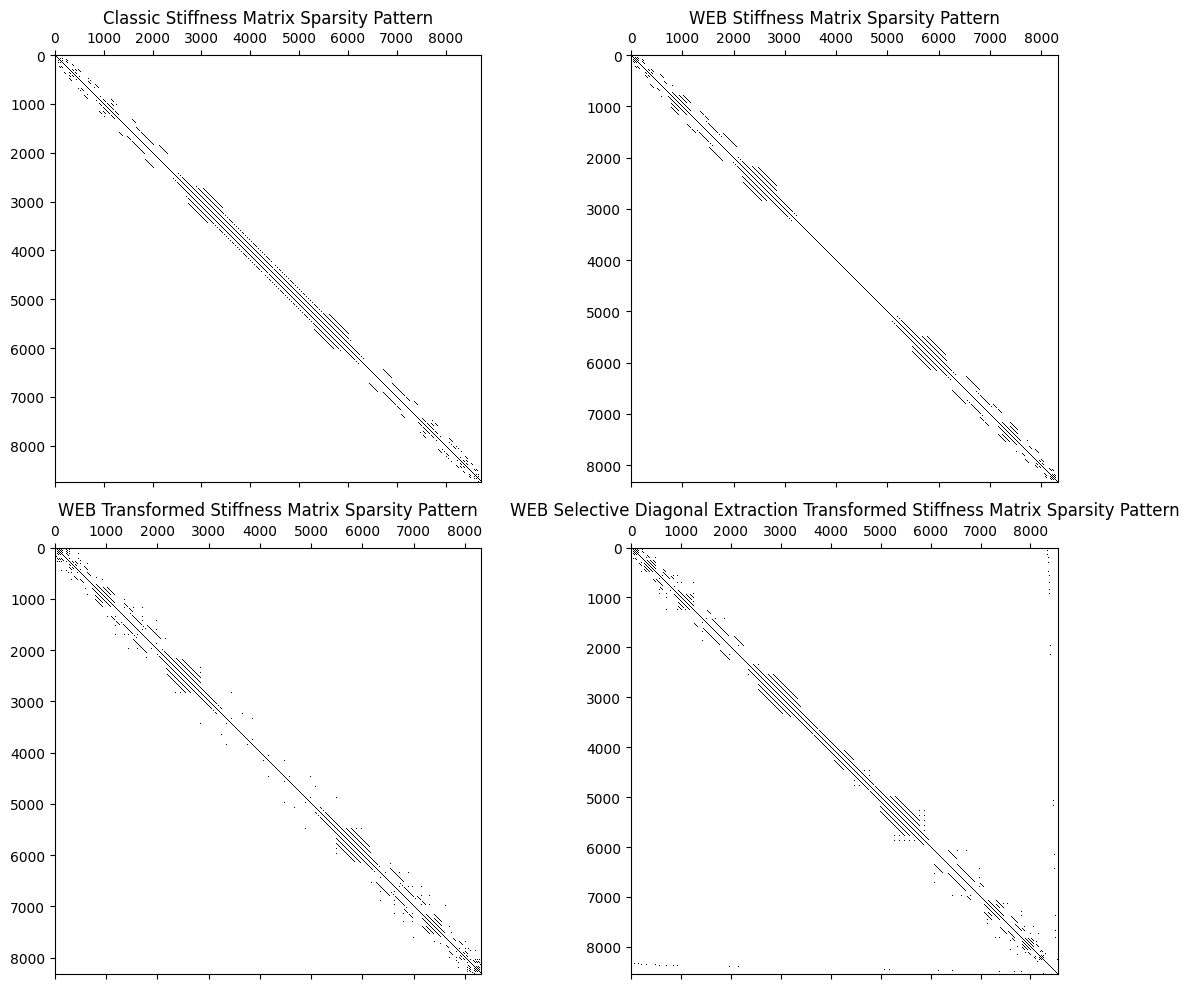

In [13]:
#create subplots to compare
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
im0 = axs[0, 0].spy(K_reduced)
axs[0, 0].set_title('Classic Stiffness Matrix Sparsity Pattern')
im1 = axs[0, 1].spy(K_reduced_W)
axs[0, 1].set_title('WEB Stiffness Matrix Sparsity Pattern')
im2 = axs[1, 0].spy(K_reduced_tilde)
axs[1, 0].set_title('WEB Transformed Stiffness Matrix Sparsity Pattern')
im3 = axs[1, 1].spy(K_reduced_tilde_s)
axs[1, 1].set_title('WEB Selective Diagonal Extraction Transformed Stiffness Matrix Sparsity Pattern')
plt.tight_layout()
plt.show()

### Main diag distribution

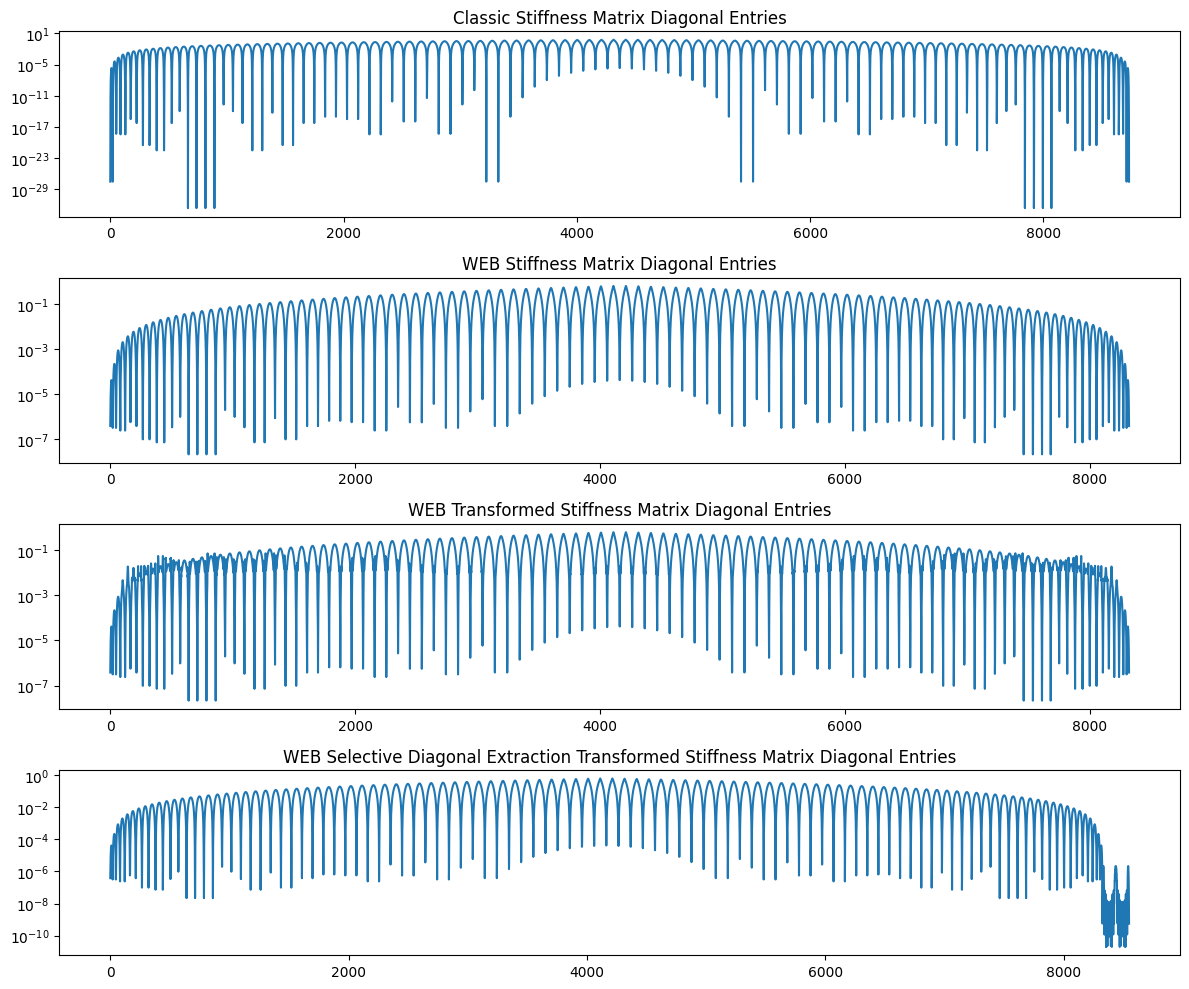

In [18]:
fig, axs = plt.subplots(4, 1, figsize=(12, 10))
im = axs[0].plot(np.abs(np.diag(K_reduced)))
axs[0].set_title('Classic Stiffness Matrix Diagonal Entries')
axs[0].set_yscale('log')
im = axs[1].plot(np.abs(np.diag(K_reduced_W)))
axs[1].set_title('WEB Stiffness Matrix Diagonal Entries')
axs[1].set_yscale('log')
im = axs[2].plot(np.abs(np.diag(K_reduced_tilde)))
axs[2].set_title('WEB Transformed Stiffness Matrix Diagonal Entries')
axs[2].set_yscale('log')
im = axs[3].plot(np.abs(np.diag(K_reduced_tilde_s)))
axs[3].set_title('WEB Selective Diagonal Extraction Transformed Stiffness Matrix Diagonal Entries')
axs[3].set_yscale('log')
plt.tight_layout()

In [20]:
# print mertics for comparison to all methods in a table
#classic
main_diag_avg = np.mean(np.abs(np.diag(K_reduced)))
main_diag_min = np.min(np.abs(np.diag(K_reduced)))
K_min = np.min(np.abs(K_reduced[np.nonzero(K_reduced)]))
F_min = np.min(np.abs(F_reduced[np.nonzero(F_reduced)]))
F_avg = np.mean(np.abs(F_reduced))

#web
main_diag_avg_W = np.mean(np.abs(np.diag(K_reduced_W)))
main_diag_min_W = np.min(np.abs(np.diag(K_reduced_W)))
K_min_W = np.min(np.abs(K_reduced_W[np.nonzero(K_reduced_W)]))
F_min_W = np.min(np.abs(F_reduced_W[np.nonzero(F_reduced_W)]))
F_avg_W = np.mean(np.abs(F_reduced_W))
#web + transform
main_diag_avg_tilde = np.mean(np.abs(np.diag(K_reduced_tilde)))
main_diag_min_tilde = np.min(np.abs(np.diag(K_reduced_tilde)))
K_min_tilde = np.min(np.abs(K_reduced_tilde[np.nonzero(K_reduced_tilde)]))
F_min_tilde = np.min(np.abs(F_reduced_tilde[np.nonzero(F_reduced_tilde)]))
F_avg_tilde = np.mean(np.abs(F_reduced_tilde))
#web + selective diag extract
main_diag_avg_tilde_s = np.mean(np.abs(np.diag(K_reduced_tilde_s)))
main_diag_min_tilde_s = np.min(np.abs(np.diag(K_reduced_tilde_s)))
K_min_tilde_s = np.min(np.abs(K_reduced_tilde_s[np.nonzero(K_reduced_tilde_s)]))
F_min_tilde_s = np.min(np.abs(F_reduced_tilde_s[np.nonzero(F_reduced_tilde_s)]))
F_avg_tilde_s = np.mean(np.abs(F_reduced_tilde_s))

#print as a table
print(f"{'Method':<40} {'Main Diag Avg':<20} {'Main Diag Min':<20} {'K Min':<20} {'F Min':<20} {'F Avg':<20}")
print(f"{'-'*150}")
print(f"{'Classic':<40} {main_diag_avg:<20.6e} {main_diag_min:<20.6e} {K_min:<20.6e} {F_min:<20.6e} {F_avg:<20.6e}")
print(f"{'WEB':<40} {main_diag_avg_W:<20.6e} {main_diag_min_W:<20.6e} {K_min_W:<20.6e} {F_min_W:<20.6e} {F_avg_W:<20.6e}")
print(f"{'WEB + Transform':<40} {main_diag_avg_tilde:<20.6e} {main_diag_min_tilde:<20.6e} {K_min_tilde:<20.6e} {F_min_tilde:<20.6e} {F_avg_tilde:<20.6e}")
print(f"{'WEB + Selective Diag Extract':<40} {main_diag_avg_tilde_s:<20.6e} {main_diag_min_tilde_s:<20.6e} {K_min_tilde_s:<20.6e} {F_min_tilde_s:<20.6e} {F_avg_tilde_s:<20.6e}")

Method                                   Main Diag Avg        Main Diag Min        K Min                F Min                F Avg               
------------------------------------------------------------------------------------------------------------------------------------------------------
Classic                                  9.680766e-02         2.323517e-33         2.323517e-33         1.768309e-20         7.862016e-04        
WEB                                      1.015579e-01         2.111298e-08         2.196732e-22         1.535245e-10         8.250943e-04        
WEB + Transform                          1.027124e-01         2.171460e-08         2.196732e-22         1.531532e-10         8.251185e-04        
WEB + Selective Diag Extract             9.893746e-02         1.993190e-11         2.196732e-22         2.662790e-11         8.034929e-04        


## Solve the lin eq system

In [21]:
#Classic solution
u_classic = FEM.solveWeak(K,F)

Max error: 1.205632815803881e-15


c:\Egyetem\Kutatás\NeuralIGA\Neural Analysis\FEM.py:541: LinAlgWarning: Ill-conditioned matrix (rcond=1.17199e-33): result may not be accurate.
  u_reduced = linalg.solve(K_reduced, F_reduced, assume_a='sym')


In [22]:
u_web = FEM_WEB.solveWEB(K_W,F_W)

Max residual: 1.47e-15


In [24]:
u_transform = FEM_WEB.solveWEB(K_tilde,F_tilde)
u_transform_cl = E_tilde.T @ u_transform

Max residual: 2.03e-15


In [25]:
u_transform_smart = FEM_WEB.solveWEB(K_tilde_s,F_tilde_s)
u_transform_smart_cl = E_tilde_s.T @ u_transform_smart

Max residual: 1.14e-15


## Compare solution vectors

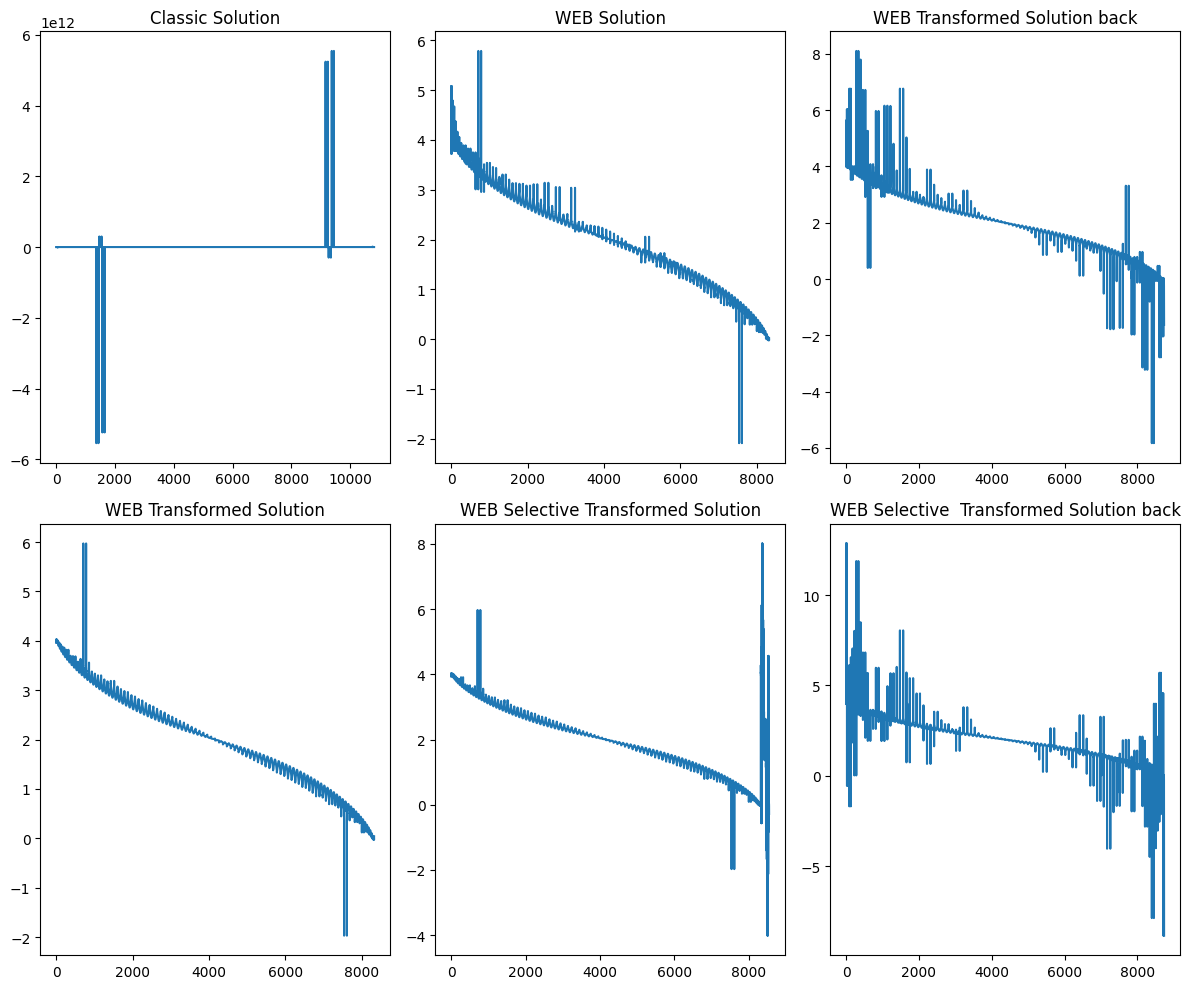

In [34]:
fig, axss = plt.subplots(2, 3, figsize=(12, 10))
im = axss[0,0].plot(u_classic)
axss[0,0].set_title('Classic Solution')
im = axss[0,1].plot(u_web)
axss[0,1].set_title('WEB Solution')
im = axss[1,0].plot(u_transform[np.nonzero(u_transform)])
axss[1,0].set_title('WEB Transformed Solution')
im = axss[1,1].plot(u_transform_smart[np.nonzero(u_transform_smart)])
axss[1,1].set_title('WEB Selective Transformed Solution')

im = axss[0,2].plot(u_transform_cl[np.nonzero(u_transform_cl)])
axss[0,2].set_title('WEB Transformed Solution back')
im = axss[1,2].plot(u_transform_smart_cl[np.nonzero(u_transform_smart_cl)])
axss[1,2].set_title('WEB Selective  Transformed Solution back')
plt.tight_layout()
plt.show()

## compare accuracies

In [30]:
metrics_classic = evaluation.evaluateAccuracy(model, u_classic, p, q, knotvector_u, knotvector_w, N=10000, seed=42)

In [31]:
import evaluation_WEB
metrics_WEB = evaluation_WEB.evaluateAccuracyWEB(model, u_web, p, q, knotvector_u, knotvector_w, bspline_classification=bsp_class_W, extended_basis=ext_basis_W, N=10000, seed=42)

In [42]:
metrics_WEB_transform = evaluation_WEB.evaluateAccuracyWEB(model, u_transform, p, q, knotvector_u, knotvector_w, bspline_classification=bsp_class_extr, extended_basis=ext_basis_extr, N=10000, seed=42)

In [36]:
metrics_WEB_trnsform_cl = evaluation.evaluateAccuracy(model, u_transform_smart_cl, p, q, knotvector_u, knotvector_w, N=10000, seed=42)

In [37]:
metrics_WEB_smart = evaluation.evaluateAccuracy(model, u_transform_smart_cl, p, q, knotvector_u, knotvector_w, N=10000, seed=42)

In [43]:
# print metrics in a table
print(f"{'Method':<40} {'MAE Error':<20} {'H1 Error':<20} {'Max Error':<20}")
print(f"{'-'*100}")
print(f"{'Classic':<40} {metrics_classic['MAE']:<20.6e} {metrics_classic['H1_error']:<20.6e} {metrics_classic['L_inf']:<20.6e}")
print(f"{'WEB':<40} {metrics_WEB['MAE']:<20.6e} {metrics_WEB['H1_error']:<20.6e} {metrics_WEB['L_inf']:<20.6e}")
print(f"{'WEB Transform':<40} {metrics_WEB_transform['MAE']:<20.6e} {metrics_WEB_transform['H1_error']:<20.6e} {metrics_WEB_transform['L_inf']:<20.6e}")
print(f"{'WEB Transform cl':<40} {metrics_WEB_trnsform_cl['MAE']:<20.6e} {metrics_WEB_trnsform_cl['H1_error']:<20.6e} {metrics_WEB_trnsform_cl['L_inf']:<20.6e}")
print(f"{'WEB smart':<40} {metrics_WEB_smart['MAE']:<20.6e} {metrics_WEB_smart['H1_error']:<20.6e} {metrics_WEB_smart['L_inf']:<20.6e}")

Method                                   MAE Error            H1 Error             Max Error           
----------------------------------------------------------------------------------------------------
Classic                                  2.111724e-06         7.887448e-04         1.295244e-04        
WEB                                      2.875606e-05         4.880754e-03         1.018909e-03        
WEB Transform                            1.977238e-06         6.954637e-04         1.099708e-04        
WEB Transform cl                         1.930717e-06         7.027150e-04         1.100627e-04        
WEB smart                                1.930717e-06         7.027150e-04         1.100627e-04        


## Show error distribution

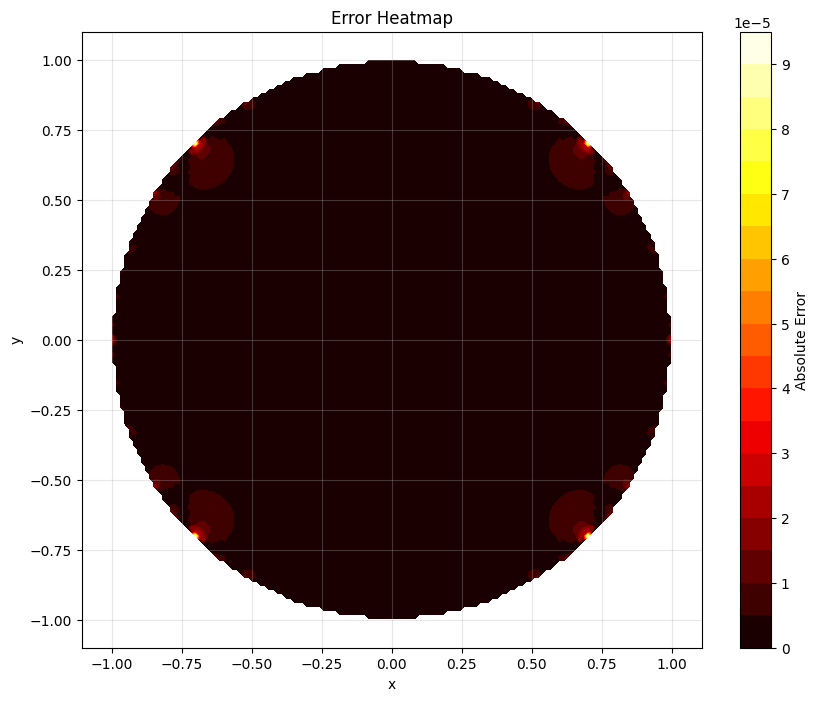

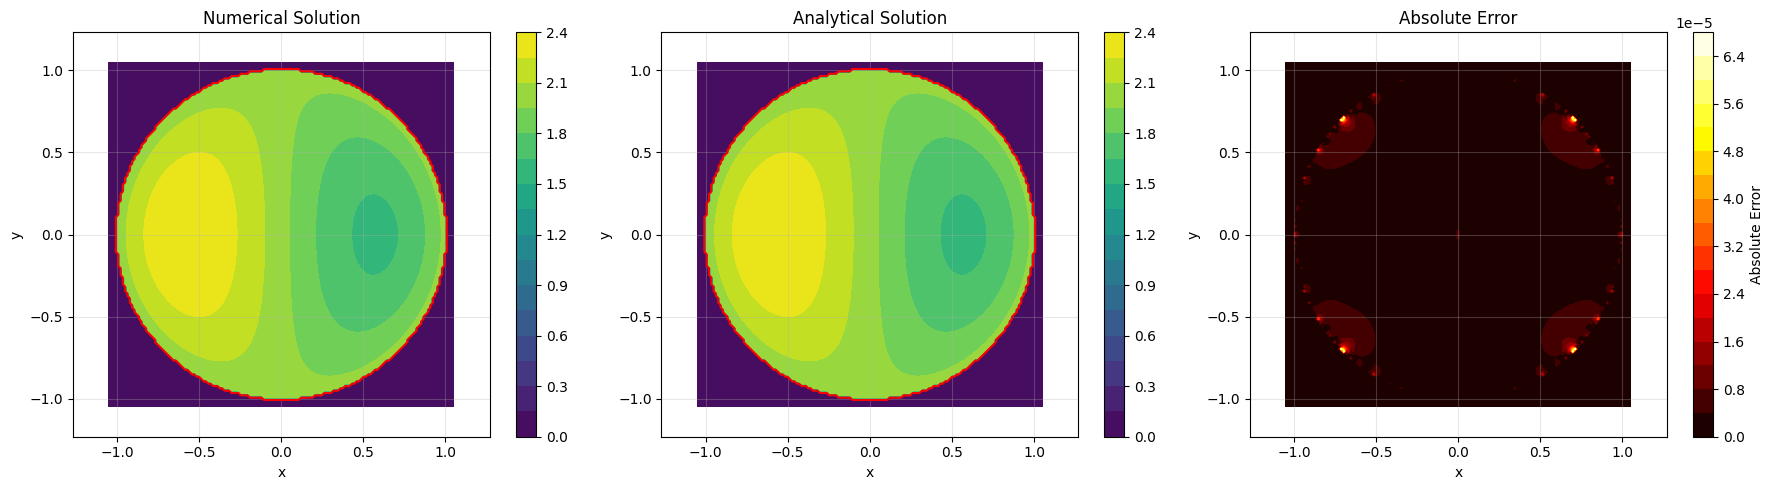

Error Statistics (inside domain):
  Max Error:  6.501691e-05
  Mean Error: 2.127558e-06
  MSE:        1.047390e-11


In [55]:
#Geomertry.init_spl(x,p,None,knotvector_u)
importlib.reload(evaluation)
evaluation.plotErrorHeatmap(model,u_classic,knotvector_u,knotvector_w,p,q,N=150)
evaluation.plotResultHeatmap(model,u_classic,knotvector_u,knotvector_w,p,q,N=150)

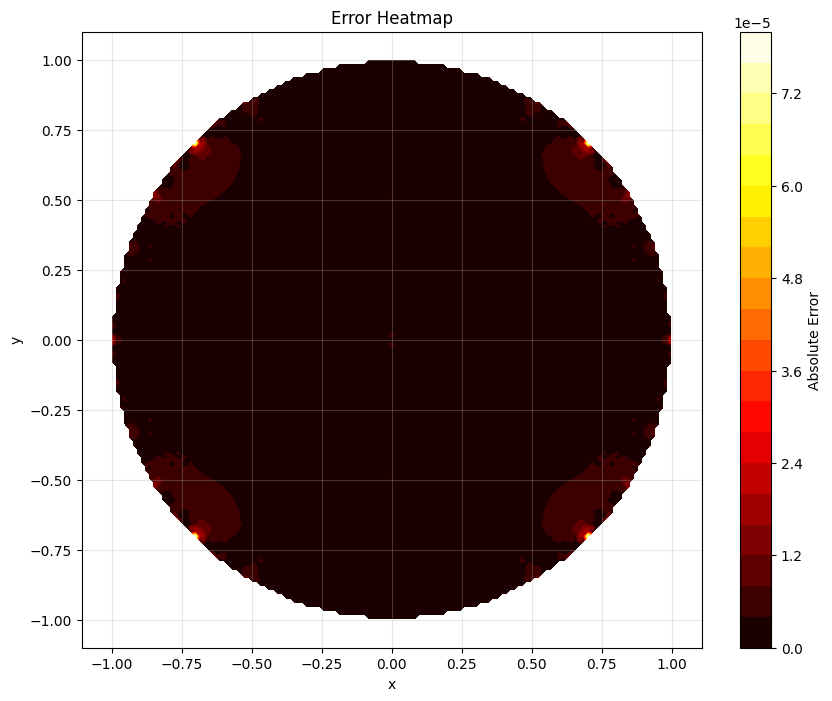

In [57]:
evaluation.plotErrorHeatmap(model,u_transform_smart_cl,knotvector_u,knotvector_w,p,q,N=150)

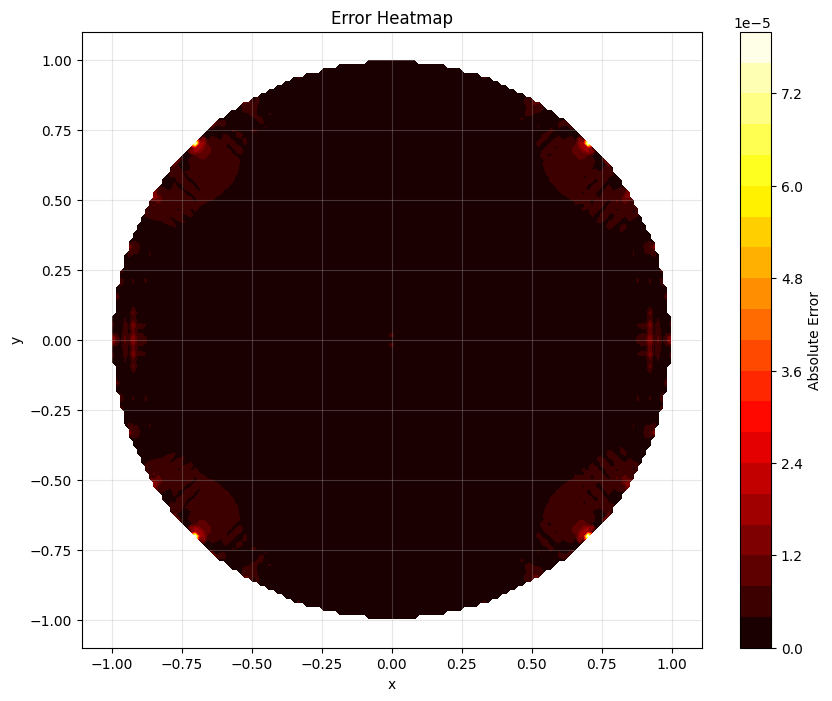

In [56]:
evaluation.plotErrorHeatmap(model,u_transform_cl,knotvector_u,knotvector_w,p,q,N=150)

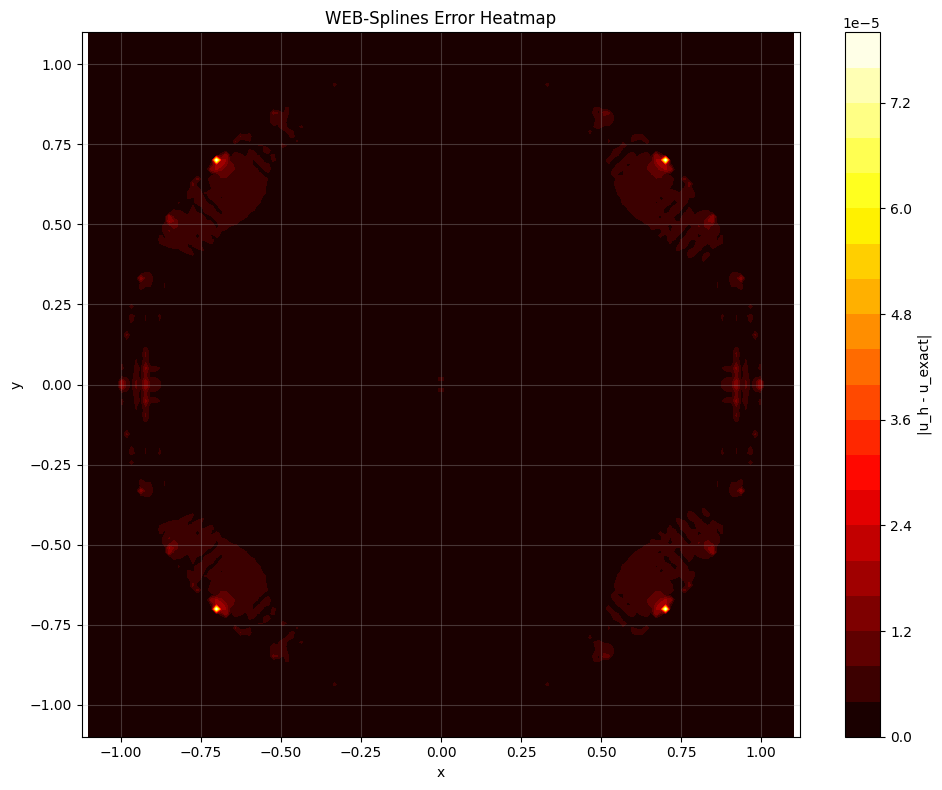

In [58]:
evaluation_WEB.plotErrorHeatmapWEB(model,u_transform,knotvector_u,knotvector_w,p,q,bsp_class_extr,ext_basis_extr,N=150)

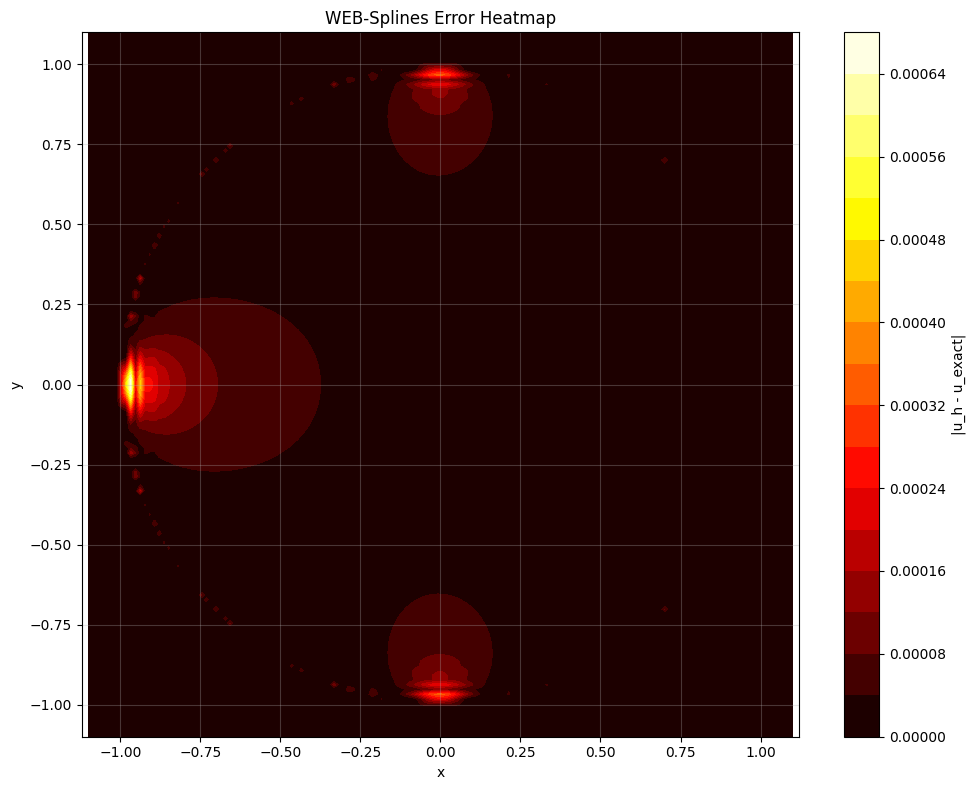

In [59]:
evaluation_WEB.plotErrorHeatmapWEB(model,u_web,knotvector_u,knotvector_w,p,q,bsp_class_W,ext_basis_W,N=150)